In [ ]:
# Import required libraries
!pip install -q datasets
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from functools import lru_cache
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from gluonts.dataset.common import ListDataset
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
from datasets import Dataset, DatasetDict

# Load training data from URL
url = 'https://raw.githubusercontent.com/saqib3171/ADML---Climate-Parameters-Forecasting-/main/DailyDelhiClimateTrain.csv'
df1 = pd.read_csv(url)
df1 = df1.set_index('date')
print(df1)

             meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]


In [ ]:
# Initialize the scaler for data normalization
scaler = StandardScaler()

# Select numeric columns to normalize (excluding the first column)
numeric_cols = df1.select_dtypes(include=[np.number]).columns[1:]

# Normalize selected columns
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])

In [ ]:
# Define target column for outlier detection
target_column = 'humidity'

# Detect and impute outliers in a specified column
def detect_and_impute_outliers(data, target_column):
    # Ensure target column exists in the data
    if target_column not in data.columns:
        raise ValueError(f"Column '{target_column}' not found in the data.")

    # Reshape data for IsolationForest
    values = data[target_column].values.reshape(-1, 1)

    # Initialize and fit IsolationForest for outlier detection
    iso_forest = IsolationForest(contamination=0.05)  # Estimate of the proportion of outliers
    outliers = iso_forest.fit_predict(values)

    # Convert outliers to a boolean mask
    outlier_mask = outliers == -1

    # Impute outliers with the median of the non-outlier values
    median_value = np.median(data.loc[~outlier_mask, target_column])
    data.loc[outlier_mask, target_column] = median_value

    return data
    # Apply outlier detection and imputation
df1 = detect_and_impute_outliers(df1, target_column)

# Display the DataFrame with imputed values
print(df1)

             meantemp  humidity  wind_speed  meanpressure
date                                                     
2013-01-01  10.000000  1.415439   -1.491699      0.025321
2013-01-02   7.400000  0.103096   -0.838196      0.037162
2013-01-03   7.166667  1.564569   -0.475626      0.041972
2013-01-04   8.666667  0.630022   -1.221233      0.033647
2013-01-05   6.000000  1.554627   -0.680303      0.029946
...               ...       ...         ...           ...
2016-12-28  17.217391  0.433776   -0.713674      0.024758
2016-12-29  15.238095  1.615699   -0.175921      0.032193
2016-12-30  14.095238  1.723641   -0.117442      0.037743
2016-12-31  15.052632  1.564569    0.114646      0.027726
2017-01-01  10.000000  0.103096   -1.491699      0.027171

[1462 rows x 4 columns]


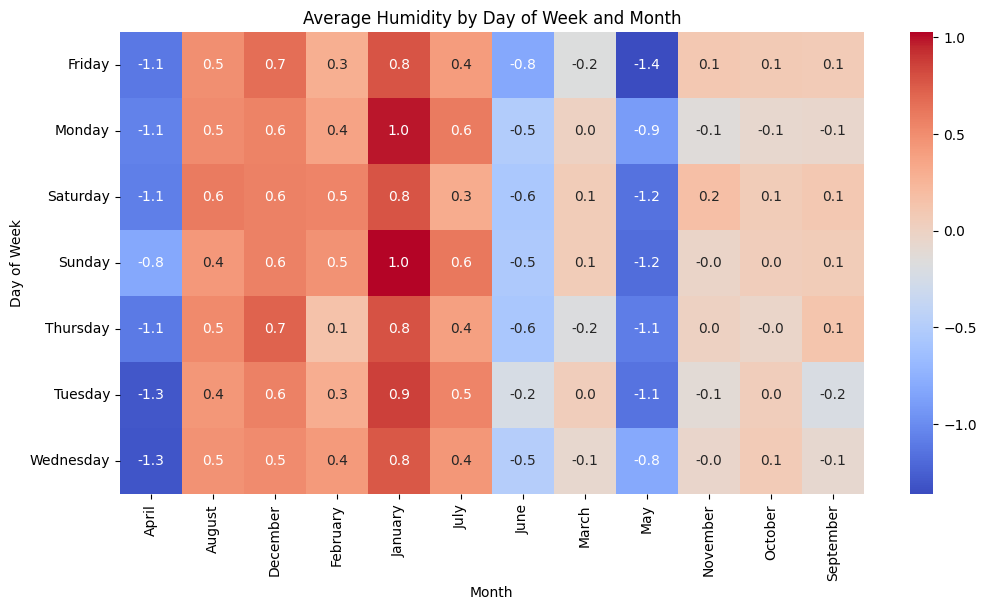

In [ ]:
# Ensuring that 'date' is a datetime object
df1['date'] = pd.to_datetime(df1.index)

# Extract day and month
df1['day_of_week'] = df1['date'].dt.day_name()
df1['month'] = df1['date'].dt.month_name()

# Pivot table
pivot = df1.pivot_table(values='humidity', index='day_of_week', columns='month', aggfunc='mean')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Average Humidity by Day of Week and Month')
plt.ylabel('Day of Week')
plt.xlabel('Month')
plt.show()


In [ ]:
# Preparing data for time series forecasting
T = 10
X = []
Y = []

# Extracting target column
target_column = 'humidity'
series = df1[target_column]

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)

print(X)
print(Y)

[[ 1.41543887  0.10309634  1.5645687  ...  0.17553083 -0.5679879
   0.07327037]
 [ 0.10309634  1.5645687   0.63002175 ... -0.5679879   0.07327037
  -0.56585748]
 [ 1.5645687   0.63002175  1.55462671 ...  0.07327037 -0.56585748
   0.78909357]
 ...
 [-0.73004232 -0.38604951 -0.17385906 ...  0.4043386   0.43377554
   1.61569893]
 [-0.38604951 -0.17385906  0.83084992 ...  0.43377554  1.61569893
   1.72364052]
 [-0.17385906  0.83084992  1.06566162 ...  1.61569893  1.72364052
   1.5645687 ]]
[-0.56585748  0.78909357  0.85868749 ...  1.72364052  1.5645687
  0.10309634]


In [ ]:
!pip install transformers
!pip install -q transformers
!pip install -q gluonts ujson
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate


In [ ]:
 # Resample the DataFrame monthly
 df1.index = pd.to_datetime(df1.index)

# Resample the data by month and get the values for each month
monthly_data = df1.resample('M').agg(lambda x: x.tolist())

# Calculate the index to split the data into train and validation
split_index = int(31/2)
split_val = int(31/2 + 31/4)

# Create 'train' and 'validation' dictionaries
train_dataset = {
    'start': monthly_data.index,
    'target': [month[:split_val] for month in monthly_data['humidity']],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

validation_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['humidity'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

test_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['humidity'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

# Create Dataset objects
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)
validation_dataset = Dataset.from_dict(validation_dataset)

# Create the DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 49
    })
    validation: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 49
    })
    test: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 49
    })
})

In [ ]:
# Display from the validation and train datasets
validation_example = dataset['validation'][0]
train_example = dataset['train'][0]
validation_example.keys()

dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'])

In [ ]:
print(validation_example['start'])
print(validation_example['target'])
print(train_example['start'])
print(train_example['target'])


2013-01-31 00:00:00
[1.4154388664959372, 0.10309634147422567, 1.5645686988847682, 0.6300217492480944, 1.5546267100588458, 1.3140305804715322, 1.0634924620582962, 0.1755308314916583, -0.5679879042755133, 0.0732703749964595, -0.56585747809853, 0.7890935704628477, 0.8586874922443023, 1.6341626206662228, 0.66126799984385, 1.5446847212329242, 1.1967151123256516, 0.10309634147422567, 0.9481653916776008, 0.8657889128342467, 0.9680493693294446, 1.1271211905441978, -0.036091502088683704, -0.006265535610917532, 0.37153003977412125, 0.20251622973344652, 0.28631299269478916, -0.2846412227367346, 0.2820521403408227, 0.576050952764518, 0.2880173336363756]
2013-01-31 00:00:00
[1.4154388664959372, 0.10309634147422567, 1.5645686988847682, 0.6300217492480944, 1.5546267100588458, 1.3140305804715322, 1.0634924620582962, 0.1755308314916583, -0.5679879042755133, 0.0732703749964595, -0.56585747809853, 0.7890935704628477, 0.8586874922443023, 1.6341626206662228, 0.66126799984385, 1.5446847212329242, 1.19671511

In [ ]:
# Set prediction frequency and length for the model
freq = "1D"
prediction_length = int(31/4)+1

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

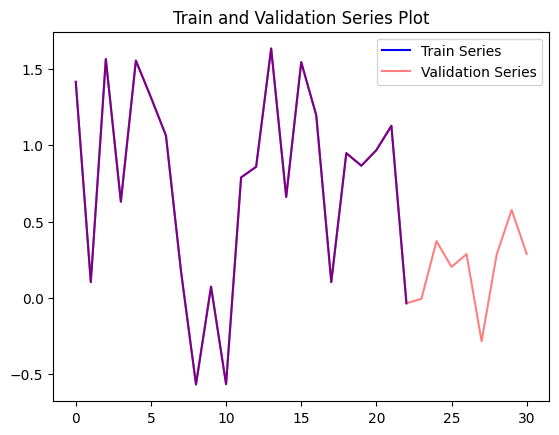

In [ ]:
# Plot actual data for training and validation datasets
figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue", label='Train Series')
axes.plot(validation_example["target"], color="red", alpha=0.5, label='Validation Series')
plt.legend()
plt.title('Train and Validation Series Plot')
plt.show()


In [ ]:
# Create data loaders for training and testing
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [ ]:
  # Converting dates and transforming start field
  def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [ ]:
# Retrieve lag sequences and time features for the given frequency
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [ ]:
# Create lag features for humidity
for i in range(1, 6):  # You can adjust the lag window
    df1[f'humidity_lag_{i}'] = df1['humidity'].shift(i)


In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7c27fa7f9240>, <function day_of_month at 0x7c27fa7f9360>, <function day_of_year at 0x7c27fa7f9480>]


In [ ]:
# Initialize the TimeSeriesTransformer model
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1,
    num_static_categorical_features=0,
    num_static_real_features=0,
    cardinality=[len(train_dataset)],
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=64,
)

model = TimeSeriesTransformerForPrediction(config)

In [ ]:
model.config.distribution_output

'student_t'

In [ ]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

        return Chain(
        # step 1: remove static/dynamic fields if not specified

        [RemoveFields(field_names=remove_field_names)]

        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches

def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([64, 1109, 4]) torch.FloatTensor
past_values torch.Size([64, 1109]) torch.FloatTensor
past_observed_mask torch.Size([64, 1109]) torch.FloatTensor
future_time_features torch.Size([64, 8, 4]) torch.FloatTensor
future_values torch.Size([64, 8]) torch.FloatTensor
future_observed_mask torch.Size([64, 8]) torch.FloatTensor


In [ ]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [ ]:
print("Loss:", outputs.loss.item())

Loss: 1.2542204856872559


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Ensure the input tensors have the correct data type
        static_categorical_features = (
            batch["static_categorical_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_categorical_features > 0
            else None
        )

        static_real_features = (
            batch["static_real_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_real_features > 0
            else None
        )

        past_time_features = batch["past_time_features"].to(device)
        past_values = batch["past_values"].to(device)
        future_time_features = batch["future_time_features"].to(device)
        future_values = batch["future_values"].to(device)
        past_observed_mask = batch["past_observed_mask"].to(device)
        future_observed_mask = batch["future_observed_mask"].to(device)

        outputs = model(
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            past_time_features=past_time_features,
            past_values=past_values,
            future_time_features=future_time_features,
            future_values=future_values,
            past_observed_mask=past_observed_mask,
            future_observed_mask=future_observed_mask,
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

1.3717145919799805
0.7998363971710205
0.8597877621650696
0.7520251870155334
0.7213821411132812
0.6718786954879761
0.6429818868637085
0.6779338121414185
0.8230625987052917
0.7194130420684814
0.7110891342163086
0.6127391457557678
0.5680425763130188
0.6019760370254517
0.5780375599861145
0.7159810066223145
0.4377656877040863
0.4113845229148865
0.37091290950775146
0.3494948744773865
0.40771353244781494
0.3767239451408386
0.19359777867794037
0.280120313167572
0.28594422340393066
0.43239301443099976
0.26181966066360474
0.1923961341381073
0.26984021067619324
0.2742195725440979
0.16078856587409973
0.14683203399181366
0.06473676860332489
0.0035021305084228516
0.05312751606106758
0.13230392336845398
-0.021848667412996292
0.25948190689086914
-0.0668986514210701
-0.20184355974197388


In [ ]:
# Model Evaulation
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts[0].shape

(49, 100, 8)

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(49, 100, 8)


In [ ]:
forecast_median = np.median(forecasts, 1)

date
2013-01-31    0.577842
2013-02-28    0.531631
2013-03-31    0.624779
2013-04-30    1.776544
2013-05-31    1.577745
2013-06-30    0.817242
2013-07-31    0.593345
2013-08-31    0.675155
2013-09-30    0.571674
2013-10-31    0.537989
2013-11-30    0.332789
2013-12-31    0.658524
2014-01-31    0.826183
2014-02-28    0.528888
2014-03-31    0.503232
2014-04-30    1.538774
2014-05-31    1.362222
2014-06-30    1.256336
2014-07-31    0.491141
2014-08-31    0.731705
2014-09-30    0.637343
2014-10-31    0.524353
2014-11-30    0.710732
2014-12-31    0.569485
2015-01-31    0.768080
2015-02-28    0.558322
2015-03-31    0.736679
2015-04-30    0.684665
2015-05-31    0.907032
2015-06-30    0.845533
2015-07-31    1.118556
2015-08-31    1.244373
2015-09-30    0.606912
2015-10-31    0.720133
2015-11-30    1.128309
2015-12-31    1.226436
2016-01-31    1.641701
2016-02-29    0.835830
2016-03-31    0.706832
2016-04-30    0.928767
2016-05-31    0.834172
2016-06-30    0.694598
2016-07-31    1.350957
2016-0

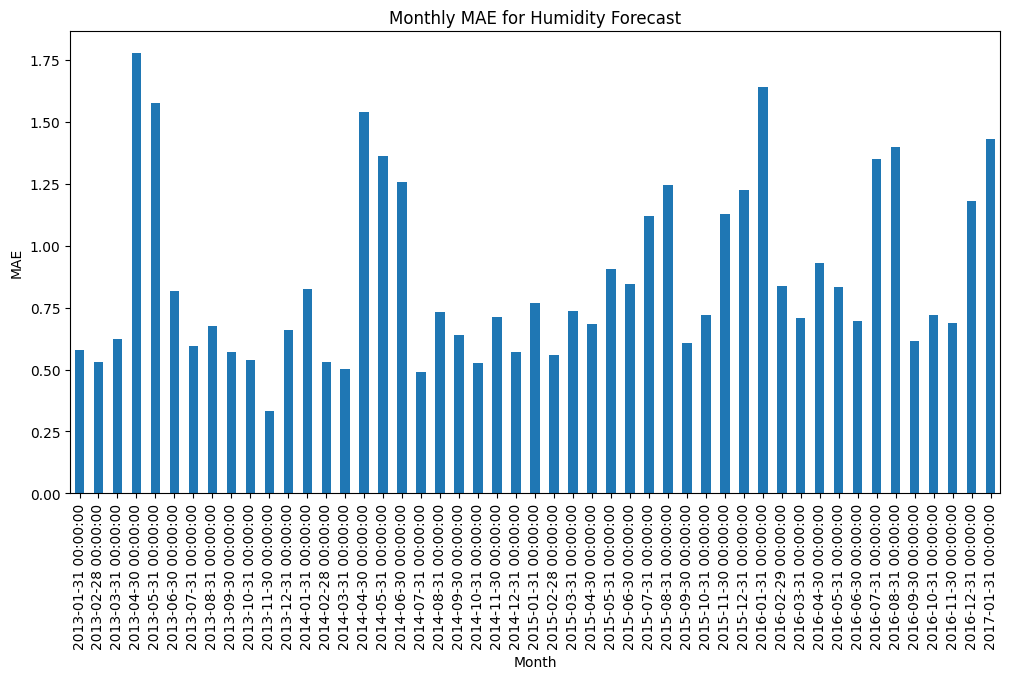

In [ ]:
# Comparing monthly forecasted humidity values with the actual observed values

# Ensure df1 index is a datetime type
df1.index = pd.to_datetime(df1.index)

# Flatten the forecasts
forecasts_flat = np.concatenate(forecasts).flatten()

# Truncate or extend forecasts_flat to match the length of df1
forecasts_flat = forecasts_flat[:len(df1)]  # Truncate if longer
if len(forecasts_flat) < len(df1):
    # Extend with NaNs if shorter
    forecasts_flat = np.pad(forecasts_flat, (0, len(df1) - len(forecasts_flat)), 'constant', constant_values=(np.nan,))

# Create a DataFrame with actual and forecast data
df_test = pd.DataFrame({
    'actual_humidity': df1['humidity'].values,  # Ensure it's 1D
    'forecast_humidity': forecasts_flat
}, index=df1.index)

# Drop rows with NaN values in either column
df_test.dropna(inplace=True)

# Group by month and calculate MAE for each month
monthly_mae = df_test.groupby(pd.Grouper(freq='M')).apply(
    lambda x: mean_absolute_error(x['actual_humidity'], x['forecast_humidity'])
)

# Print & plot monthly MAE
print(monthly_mae)
monthly_mae.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Month')
plt.ylabel('MAE')
plt.title('Monthly MAE for Humidity Forecast')
plt.show()


In [ ]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=validation_dataset[ts_index][FieldName.START],
        periods=len(validation_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # Minor ticks every 6 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    ax.plot(
        index,
        validation_dataset[ts_index]["target"],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

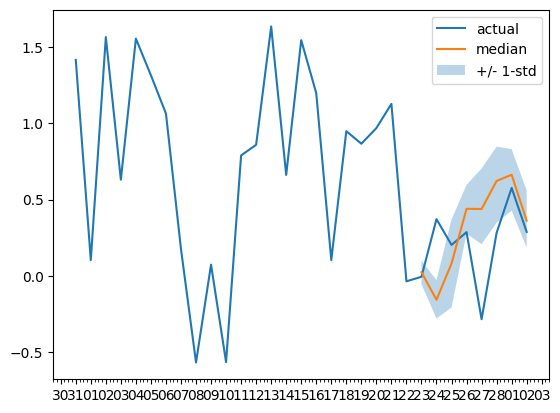

In [ ]:
ts_index = 0

#  plot function with the ts_index
plot(ts_index)


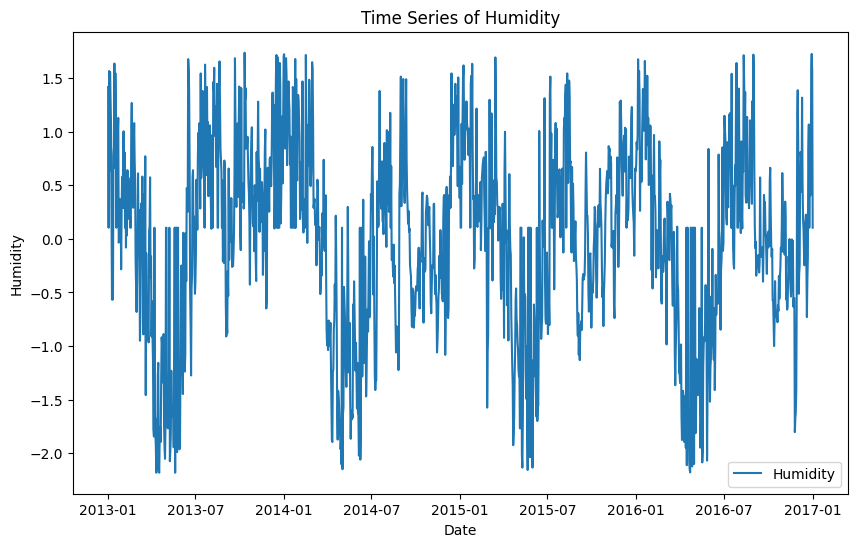

In [ ]:
# Plot of original time series data
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1['humidity'], label='Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.title('Time Series of Humidity')
plt.legend()
plt.show()

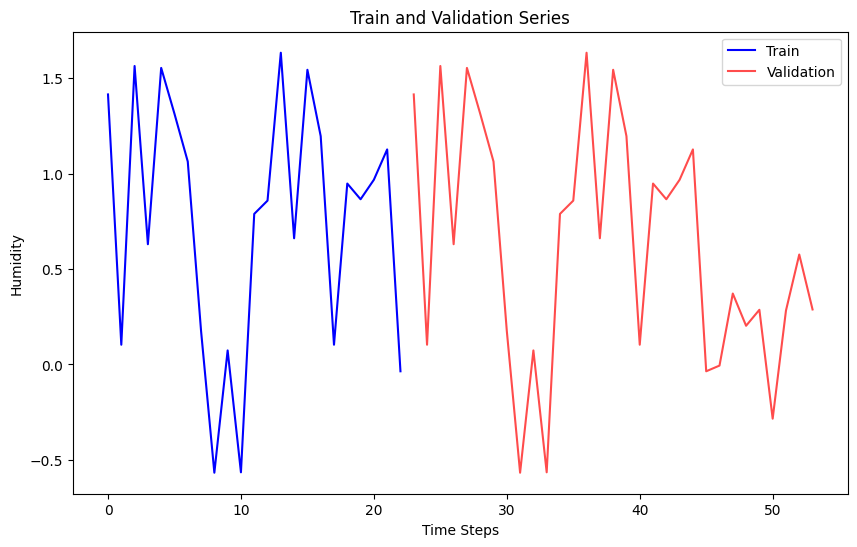

In [ ]:
# Plot of Train and Validation Examples
plt.figure(figsize=(10, 6))
plt.plot(train_example["target"], label='Train', color='blue')
plt.plot(range(len(train_example["target"]), len(train_example["target"]) + len(validation_example["target"])), validation_example["target"], label='Validation', color='red', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Humidity')
plt.title('Train and Validation Series')
plt.legend()
plt.show()

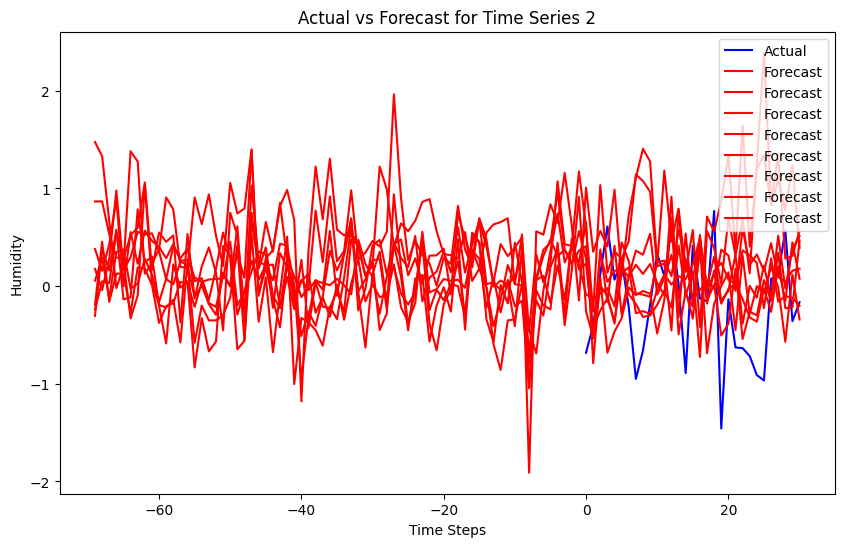

In [ ]:
# Comparison of Actual vs. Forecasted Data
import matplotlib.pyplot as plt

def plot_forecast(ts_index):
    actual = validation_dataset[ts_index]['target']
    forecast = forecasts[ts_index]

    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(range(len(actual) - len(forecast), len(actual)), forecast, label='Forecast', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Humidity')
    plt.title(f'Actual vs Forecast for Time Series {ts_index}')
    plt.legend()
    plt.show()

# To display the plot for the first time series
plot_forecast(2)


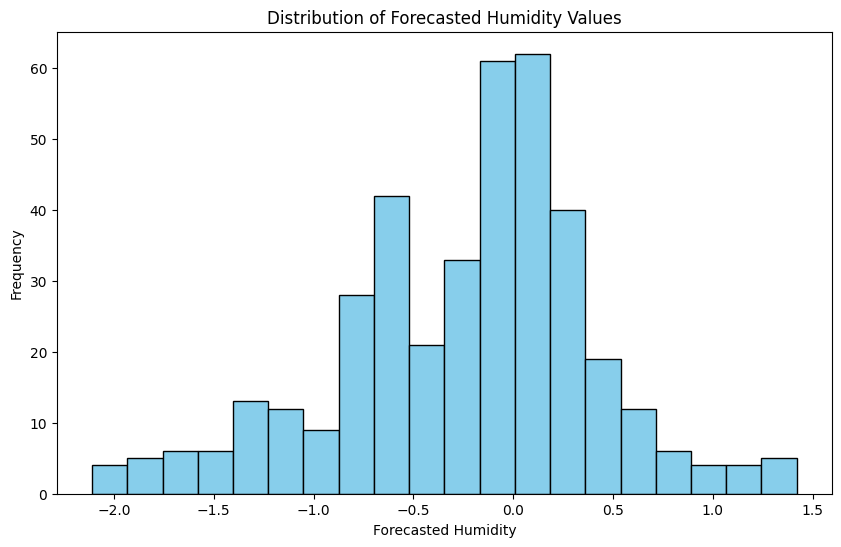

In [ ]:
# Plot the distribution of forecasted values
plt.figure(figsize=(10, 6))
plt.hist(forecast_median.flatten(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Forecasted Humidity')
plt.ylabel('Frequency')
plt.title('Distribution of Forecasted Humidity Values')  # Title for the histogram of forecasted values
plt.show()


In [ ]:
# Test model with given test data file
from datasets import Dataset, DatasetDict
from functools import partial

# Convert date to pandas period
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

# Transform start field
def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

# 1. Load the Test Data
test_url = 'https://raw.githubusercontent.com/saqib3171/ADML---Climate-Parameters-Forecasting-/main/DailyDelhiClimateTest.csv'
df_test = pd.read_csv(test_url)
df_test = df_test.set_index('date')
df_test.index = pd.to_datetime(df_test.index)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from gluonts.dataset.common import ListDataset

# Select numeric columns to normalize (excluding the first column)
numeric_cols2 = df_test.select_dtypes(include=[np.number]).columns[1:]

# Normalize selected columns
df_test[numeric_cols2] = scaler.fit_transform(df_test[numeric_cols2])

 # Apply outlier detection and imputation
#df_test = detect_and_impute_outliers(df_test, target_column)

# Preprocess the Test Data
monthly_test_data = df_test.resample('M').apply(lambda x: x.tolist())

# Create 'test' dictionary
test_dataset = {
    'start': monthly_test_data.index,
    'target': [month.humidity for month in monthly_test_data.itertuples()],
    'item_id': list(range(1, len(monthly_test_data) + 1)),
    'feat_dynamic_real': len(monthly_test_data) * [None],
    'feat_static_cat': list(range(1, len(monthly_test_data) + 1))
}

# Create Dataset object
test_dataset = Dataset.from_dict(test_dataset)

# Transform the test dataset
freq = "1D"
test_dataset.set_transform(partial(transform_start_field, freq=freq))

# 3. Create a DataLoader for the Test Dataset
test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64
)

# 4. Predict Using the Model
model.eval()

test_forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    test_forecasts.append(outputs.sequences.cpu().numpy())

test_forecasts = np.vstack(test_forecasts)

# Display the forecast results
print(test_forecasts)

[[[ 7.6708513e-01  4.1226956e-01 -5.7032004e-02 ...  5.3642315e-01
    2.0928229e-01  8.3852105e-02]
  [ 5.7061964e-01  1.8460892e-01 -2.3464508e-01 ...  6.3059789e-01
    3.4487036e-01  6.3246143e-01]
  [ 7.6649791e-01  1.1675427e+00  8.8796604e-01 ...  7.6725341e-02
    2.8008917e-01 -2.4908598e-01]
  ...
  [ 3.4229439e-01  5.9194434e-01  1.4594468e-01 ... -5.4415524e-02
    3.2735088e-01 -2.1072662e-01]
  [ 5.9382200e-01  3.0306986e-01  9.0276487e-02 ... -3.0529413e-01
   -7.2310641e-02 -2.3434494e-01]
  [ 5.7097828e-01  5.2306509e-01  7.0212191e-01 ... -4.0938396e-02
   -3.1324360e-01 -4.3391329e-01]]

 [[-2.0669554e-01 -3.2715648e-01 -2.0112397e-01 ... -5.5791796e-03
   -2.9868412e-01 -5.8548337e-01]
  [-3.9995638e-01 -5.1292583e-02 -8.6585693e-02 ...  1.7917340e-01
   -2.1437725e-01 -4.4452915e-01]
  [-2.1877775e-01 -4.9617652e-02 -2.9264358e-01 ... -3.9353740e-01
   -3.9495611e-01 -4.7616738e-01]
  ...
  [-6.1111324e-02 -4.6676531e-02 -4.2738404e-02 ... -2.9745191e-02
   -2.3179

In [ ]:
# Get actual values for the validation dataset
def get_actual_values(validation_dataset):
    # Extract the actual values for the validation dataset's prediction period
    actual_values = [series['target'] for series in validation_dataset]
    return np.concatenate(actual_values)

# Get actual values for the validation dataset
actual_values_flat = get_actual_values(validation_dataset)

# Extract the relevant slice from the forecasts for validation
# Assuming we are interested in the first feature of the first time series
forecasts_slice = forecasts[:, :, 0]  # Adjust indices as required

# Flatten the slice for comparison
forecasts_flat = forecasts_slice.flatten()

# Ensure the length of forecasts matches the length of actual values
if len(forecasts_flat) != len(actual_values_flat):
    # If lengths don't match, pad the shorter array with zeros or another appropriate value
    if len(forecasts_flat) < len(actual_values_flat):
        forecasts_flat = np.pad(forecasts_flat, (0, len(actual_values_flat) - len(forecasts_flat)))
    else:
        actual_values_flat = np.pad(actual_values_flat, (0, len(forecasts_flat) - len(actual_values_flat)))

# Calculate the error metrics
mae = mean_absolute_error(actual_values_flat, forecasts_flat)
print(f"Mean Absolute Error (MAE) on Validation Data: {mae}")


Mean Absolute Error (MAE) on Validation Data: 0.7374220861406259


In [ ]:
import math

# Function to get actual values for the test dataset
def get_actual_values(test_dataset):
    # Extract the actual values for the test dataset's prediction period
    actual_values = [series['target'][-prediction_length:] for series in test_dataset]
    return np.concatenate(actual_values)

# Get actual values for the test dataset
actual_values_flat = get_actual_values(test_dataset)

# Extract the relevant slice from the forecasts
# Assuming we are interested in the first feature of the first time series
forecasts_slice = test_forecasts[0, :, 0]  # we can adjust indices as required

# Flatten the slice for comparison
forecasts_flat = forecasts_slice.flatten()

# Ensure the length of forecasts matches the length of actual values
if len(forecasts_flat) > len(actual_values_flat):
   forecasts_flat = forecasts_flat[:len(actual_values_flat)]

# Calculate the error metrics
if len(actual_values_flat) == len(forecasts_flat):
    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values_flat, forecasts_flat)
    print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.199082302494966
